# Spread Entries


---

## Collect Data

Impirt librarys and set matplotlib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time
import dateutil.parser
import requests
from typing import List, Dict

# from sklearn.linear_model import LinearRegression 
from scipy.stats import linregress, zscore
from scipy.interpolate import interp1d
import statsmodels.api as sm

%matplotlib inline
plt.rcParams['figure.figsize'] = [17, 7]

Pull data directly from bitmex using the REST API

In [3]:
def collect_data(from_time: str, to_time: str, tf: str, contract: str = "ETHUSD") -> pd.DataFrame:

    url = "https://www.bitmex.com/api/v1/trade/bucketed"
    candles = {'timestamp': [], 'close': []}

    # Set inputs
    data = dict()
    data['symbol'] = contract
    data['partial'] = True  # returns a candle if it is not finished yet
    data['binSize'] = tf
    data['count'] = 500   # how many candles we can return (500 max)
    data['reverse'] = True

    data["startTime"] = datetime.datetime.strptime(from_time, '%Y-%m-%d %H:%M')
    data["endTime"] = datetime.datetime.strptime(to_time, '%Y-%m-%d %H:%M')

    BITMEX_TF_MINUTES = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "1d": 1440}


    try:
        response = requests.get(url, params=data)
    except Exception as e:
        print(f"Connecton error while making GET request to {url}: {e}")
        return

    if response.status_code == 200:
        raw_candles = response.json()
    else:
        print(f"Error while making GET request to {url}: {response.status_code}")
        print(response.headers)
        return None
    
    if raw_candles is not None:
        for idx, c in enumerate(reversed(raw_candles)):
            ts = dateutil.parser.isoparse(c['timestamp'])
            ts = ts - datetime.timedelta(minutes=BITMEX_TF_MINUTES[tf])
            candles['timestamp'].append(ts)
            candles["close"].append(c["close"])


    return pd.DataFrame(candles)

Buid the `DataFrame`

In [7]:
from_time = "2022-07-22 10:00"
to_time = "2022-07-23 10:00"
tf = "5m"
contract = "AXSUSD"

data = collect_data(from_time, to_time, tf, contract)

data['sma_30'] = data['close'].rolling(window=30).mean()
data

,timestamp,close,sma_30
0,2022-07-22 09:55:00+00:00,16.13,NaN
1,2022-07-22 10:00:00+00:00,16.13,NaN
2,2022-07-22 10:05:00+00:00,16.13,NaN
3,2022-07-22 10:10:00+00:00,16.13,NaN
4,2022-07-22 10:15:00+00:00,16.13,NaN
...,...,...,...
284,2022-07-23 09:35:00+00:00,17.45,16.833667
285,2022-07-23 09:40:00+00:00,17.65,16.882000
286,2022-07-23 09:45:00+00:00,17.76,16.934000
287,2022-07-23 09:50:00+00:00,17.43,16.975000


We will just use a SMA cross over strategy for this as the actual alpha isn't important to test the spread entry / exits 

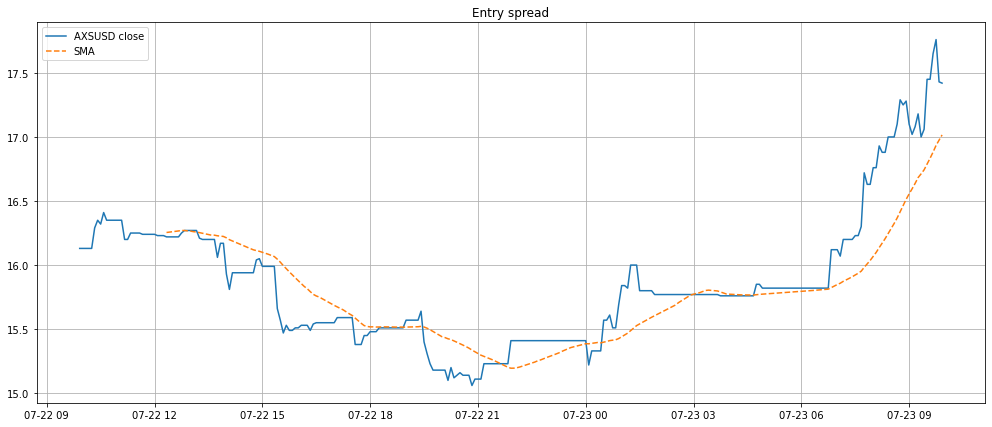

In [9]:
title = "Entry spread"
x, y = data['timestamp'], data['close']
sma = data['sma_30']

plt.plot(x, y, '-', label=f"{contract} close")
plt.plot(x, sma, '--', label="SMA")

plt.title(title)
plt.grid()
plt.legend()
plt.show()